In [ ]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import MiniBatchKMeans

import heapq as heap
import numpy as np

def _is_clusterer(inobj):
    "Returns true of the passed object is a scikit-learn clusterer"
    return isinstance(inobj, ClusterMixin)

def _make_clusterer_seqfn(incl):
    "Turns a passed clusterer into a sequence-based function"

    def groupfn(inarray, indicies):
        clusters = incl.fit_predict(inarray)
        group_dict = {}
        index = 0
        for (ind, clid) in enumerate(clusters):
            if clid in group_dict:
                group_dict[clid].append(ind)
            else:
                group_dict[clid] = [ind]

        #a way to make this a view...?
        return ((inarray[inds], indicies[inds])
                for inds in group_dict.itervalues())

    return groupfn

class _heap_fit_by(object):
    "class for allowing custom metrics in heap"
    def __init__(self, inpoints, score):
        self.data = inpoints
        self.score = score

    def __less__(self, other): #we want highest scores to be processed
        return self.score > other.score

def _len_predicate(x, clusterer):
    return x

class SplittingClustering(BaseEstimator, ClusterMixin):
    """
    Splitting Clustering

    Recursively splits clusters using a given clusterer

    Parameters
    ----------
    n_clusters : int, default = 2
        The minimum of clusters that will be found.
        The algorithm will split clusters until the numbers
        of clusters is >= n_clusters. If the split that passes
        this number generates many child clusters, they will be used.
        By default, this algorithm uses bisecting kmeans and will return
        exactly n_clusters clusters

    cluster_cutoff : int, default 1
        The size of a list of points for which
        the algorithm will cease clustering

    clusterer : scikit-learn clusterer or callable, default MiniBatchKmeans
        The clusterer used to cluster the data.
        A passed scikit-learn clusterer will only accept datatypes that
        can perform advanced indexing on rows (i.e. arr[[1, 2, 3]])
        If passed a callable, the callable should return a sequence of clusters.
        In addition, the callable should expect to be able to take
        the input passed to the fit function and the cluster type it returns
        along with the the current set of indicies (1d numpy array)


    keep_hierarchy : boolean, default False
        If True then the tree constructed by the algorithm will be kept,
        but only the parts required to create the clusters.
    """
    def __init__(self,
                 n_clusters=2,
                 split_predicate=_len_predicate,
                 clusterer=None,
                 cluster_cutoff=1,
                 keep_hierarchy=False):

        if clusterer is None:
            clusterer = MiniBatchKMeans(n_clusters=2)
        if _is_clusterer(clusterer):
            clusterer = _make_clusterer_seqfn(clusterer)

        self.clusterer = clusterer
        self.n_clusters = n_clusters
        self.cluster_cutoff = cluster_cutoff
        self.keep_hierarchy = keep_hierarchy

        self._tree = None
        self._finished = False
        self.labels_ = None

    def fit(self, X, y=None):
        """
        Computes the cluster labels and hierarchy

        Parameters
        ----------
        X : array-like or sparse matrix (or whatever the clusterer takes...)

        """
        self._finished = False
        self._labels = np.empty(len(X))
        self._labels[:] = -1
        self._strict_fit(X)
        return self

    def fit_predict(self, X, y=None):
        """
        Performs clustering on X and returns cluster labels.
        Equivalent to calling fit()

        Parameters
        ----------
        X : array-like or sparse matrix (or whatever the given clusterer takes)

        Returns
        -------
        y : ndarray, shape (n_samples,)
            cluster labels
        """
        # non-optimized default implementation; override when a better
        # method is possible for a given clustering algorithm
        self.fit(X)
        return self.labels_


    def _set_indicies(self, clnum, inds):
        "initializes the labels"
        for i in inds:
            self._labels[i] = clnum

    def _strict_fit(self, X):
        "performs the actual clustering and analysis of the tree"
        nclusters = self.n_clusters

        ssort = lambda x, incl: _heap_fit_by(x, self.split_predicate(x, incl))
        clusters = [_heap_fit_by(X, 0)] #score doesn't matter here
        clnum = 0

        # Keep generating more splits until n_clusters has been satisfied
        # The tree is generated lazily, so n_clusters = 2 will only cluster once
        while clnum < nclusters:

            # ran out of clusters, shouldn't happen unless bad parameters
            # or clusterers are passed.

            to_split = heap.heappop(clusters).data

            #to_split = 
            for x in to_split["children"]:
                if "children" not in x: # x is a final cluster
                    self._set_indicies(clnum, to_split["cluster"])
                    clnum += 1
                else: # x is still a candidate for splitting
                    heap.heappush(clusters, ssort(x))

        #update final indices in labels
        for x in clusters:
            dat = x.data
            self._set_indicies(clnum, dat["cluster"])
            if "children" in dat: # clear out extra references to clusters
                del dat["children"]

        self._finished = True


In [1]:
import math

def l2_norm(x): #function to calculate L2 norm of a vector
	'''
	arguement
	---------
	x - the vector
	returns - L2 norm of the vector
	'''
	sum = 0
	for i in range(len(x)):
		sum += x[i]**2
	return math.sqrt(sum)

def SimilarityMeasure(data1, data2, type='L2'):
	'''
	arguements 
	----------
	data1, data2 - vectors, between which we are going to calculate similarity
	returns
	-------
	distance between the two vectors
	'''
	if type=='L2':
		# for L2 norm or pythagorean distance
		dist = 0
		for i in range(4):
			dist += (data1[i] - data2[i] )**2

		dist = math.sqrt(dist)
		return dist

	if type=='Cosine':
		# form cosine similarity = a.b/|a|.|b|
		dot_prod = 0
		data1_mod = l2_norm(data1)
		data2_mod = l2_norm(data2)
		for x in range(4):
			dot_prod += data1[x]*data2[x]
		return (dot_prod/(data1_mod*data2_mod))

	else:
		print('Please provide proper similarity measurement type')
		return 0

In [2]:
import numpy as np 
from pathlib import Path
import pandas as pd 
import pickle

def DistanceMatrix(data =None):
  '''
  arguement
  ---------
  data - the dataset whose Similarity matrix we are going to calculate
  returns
  -------
  the distance matrix by loading th pickle file
  '''
  #pickleFilePath = Path('SimMat.pkl') #checking if the distance matrix was saved from last run to save processing
  Data_list = data.values.tolist()
  # for index, rows in data.iterrows():
  # 	my_data = [rows.Hobby, rows.Age, rows.Educational_Level, rows.Marital_Status]
  # 	Data_list.append(my_data)

  # if pickleFilePath.is_file():
  # 	temp_file=open(pickleFilePath, 'rb')
  # 	return pickle.load(temp_file)

  #else:
  N = len(data)
  similarity_mat = np.zeros([N, N]) #for cosine np.ones
  for i in range(N):
    for j in range(N):
      similarity_mat[i][j]=SimilarityMeasure(Data_list[i],Data_list[j])

  return similarity_mat
  #   with open('SimMat.pkl', 'wb') as file:
  #     pickle.dump(similarity_mat, file)

  # temp_file=open(pickleFilePath, 'rb')
  # return pickle.load(temp_file)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd 


#this is the main class that computes the clusters using diana algorithm
class DianaClustering:   
	def __init__(self,data): 
		'''
		constructor of the class, it takes the main data frame as input
		'''
		self.data = data  
		self.n_samples, self.n_features = data.shape

	def fit(self,n_clusters):
		'''
		this method uses the main Divisive Analysis algorithm to do the clustering
		arguements
		----------
		n_clusters - integer
					 number of clusters we want
		
		returns
		-------
		cluster_labels - numpy array
						 an array where cluster number of a sample corrosponding to 
						 the same index is stored
		'''
		similarity_matrix = DistanceMatrix(self.data) # similarity matrix of the data
		clusters = [list(range(self.n_samples))]      # list of clusters, initially the whole dataset is a single cluster
		while True:
			c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
			max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
			max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
			splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
			last_clusters = clusters[max_cluster_dia]
			del last_clusters[max_difference_index]
			while True:
				split = False
				for j in range(len(last_clusters))[::-1]:
					splinter_distances = similarity_matrix[last_clusters[j], splinters]
					last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
					if np.mean(splinter_distances) <= np.mean(last_distances):
						splinters.append(last_clusters[j])
						del last_clusters[j]
						split = True
						break
				if split == False:
					break
			del clusters[max_cluster_dia]
			clusters.append(splinters)
			clusters.append(last_clusters)
			if len(clusters) == n_clusters:
				break

		cluster_labels = np.zeros(self.n_samples)
		for i in range(len(clusters)):
			cluster_labels[clusters[i]] = i

		return cluster_labels 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import gdown
import seaborn as sb

import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics as metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [6]:
gdown.download('https://docs.google.com/uc?export=download&id=16DnkCI2ORqbHR3GmEnA6BGNgyjqvHcYP','data.csv',quiet=True)

'data.csv'

In [12]:
data = pd.read_csv('data.csv')
data.rename(columns={'Unnamed: 0':'Sl_num'},inplace=True)
data['ShortPassing'].fillna(data['ShortPassing'].mean(), inplace = True)
data['Volleys'].fillna(data['Volleys'].mean(), inplace = True)
data['Dribbling'].fillna(data['Dribbling'].mean(), inplace = True)
data['Curve'].fillna(data['Curve'].mean(), inplace = True)
data['FKAccuracy'].fillna(data['FKAccuracy'], inplace = True)
data['LongPassing'].fillna(data['LongPassing'].mean(), inplace = True)
data['BallControl'].fillna(data['BallControl'].mean(), inplace = True)
data['HeadingAccuracy'].fillna(data['HeadingAccuracy'].mean(), inplace = True)
data['Finishing'].fillna(data['Finishing'].mean(), inplace = True)
data['Crossing'].fillna(data['Crossing'].mean(), inplace = True)
data['Weight'].fillna('200lbs', inplace = True)
data['Contract Valid Until'].fillna(2019, inplace = True)
data['Height'].fillna("5'11", inplace = True)
data['Loaned From'].fillna('None', inplace = True)
data['Joined'].fillna('Jul 1, 2018', inplace = True)
data['Jersey Number'].fillna(8, inplace = True)
data['Body Type'].fillna('Normal', inplace = True)
data['Position'].fillna('ST', inplace = True)
data['Club'].fillna('No Club', inplace = True)
data['Work Rate'].fillna('Medium/ Medium', inplace = True)
data['Skill Moves'].fillna(data['Skill Moves'].median(), inplace = True)
data['Weak Foot'].fillna(3, inplace = True)
data['Preferred Foot'].fillna('Right', inplace = True)
data['International Reputation'].fillna(1, inplace = True)
data['Wage'].fillna('€200K', inplace = True)

data.fillna(0, inplace = True)
data.columns

Index(['Sl_num', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackl

In [13]:
data.isnull().sum()

Sl_num            0
ID                0
Name              0
Age               0
Photo             0
                 ..
GKHandling        0
GKKicking         0
GKPositioning     0
GKReflexes        0
Release Clause    0
Length: 89, dtype: int64

In [14]:
data = data.select_dtypes(exclude=['object'])
data = data.drop(['Sl_num', 'ID', 'Jersey Number'], axis='columns')
data.head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,2202,5.0,4.0,4.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,2228,5.0,4.0,5.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,2143,5.0,5.0,5.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,1471,4.0,3.0,1.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,2281,4.0,5.0,4.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [15]:
print(data.shape)
data=data[:6000]
print(data.shape)


(18207, 41)
(1000, 41)


In [16]:
# di = SplittingClustering(n_clusters = 5)
# y_pred = di.fit_predict(data)
diana = DianaClustering(data) #applying the Diana Clustering algorithm
y_pred = diana.fit(5)
y_pred

array([0., 0., 0., 3., 0., 0., 0., 1., 0., 4., 0., 0., 1., 0., 0., 0., 0.,
       0., 4., 4., 0., 0., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 4., 1., 0., 4., 4., 0., 1., 2., 0., 4., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 0., 4., 0., 0., 0.,
       0., 0., 0., 3., 1., 0., 0., 4., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 2., 0., 2., 2., 0., 1., 0., 2., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 4., 2., 4., 0., 0., 4., 0., 4., 0., 0.,
       0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 2., 4., 0., 4., 2., 0., 2.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 2., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 2., 0., 4., 0., 0., 3., 2., 1., 1., 0., 0., 0.,
       0., 1., 4., 0., 1., 0., 0., 0., 0., 4., 4., 0., 0., 0., 4., 3., 0.,
       2., 0., 1., 0., 0., 0., 4., 1., 4., 4., 4., 1., 0., 0., 4., 0., 0.,
       1., 4., 0., 4., 4.

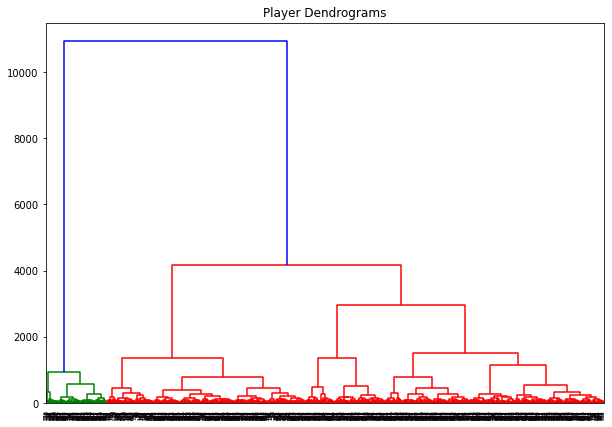

In [19]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Player Dendrograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [ ]:
data['clusters']=y_pred
